In [57]:
import pandas as pd
import numpy as np
from pandas_datareader import data, wb
import matplotlib as mpl
from mplfinance.original_flavor import candlestick_ohlc
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import plot, iplot
import matplotlib.dates as dates
import datetime


In [58]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

In [59]:
df=data.DataReader('F', 'yahoo', start, end)

df['Dates'] = dates.date2num(df.index)

period9_high = df['High'].rolling(window=9).max()
period9_low = df['Low'].rolling(window=9).min()
df['Tenkan-sen'] = (period9_high + period9_low) / 2

period26_high = df['High'].rolling(window=26).max()
period26_low =  df['Low'].rolling(window=26).min()
df['Kijun-sen'] = (period26_high + period26_low) / 2

df['Senkou-span_1'] = ((df['Tenkan-sen'] + df['Kijun-sen']) / 2).shift(26)

period52_high = df['High'].rolling(window=52).max()
period52_low = df['Low'].rolling(window=52).min()
df['Senkou-span_2'] = ((period52_high + period52_low) / 2).shift(26)

df['Chikou-span'] = df['Close'].shift(-26)

df

,High,Low,Open,Close,Volume,Adj Close,Dates,Tenkan-sen,Kijun-sen,Senkou-span_1,Senkou-span_2,Chikou-span
Date,,,,,,,,,,,,
2000-01-03,29.228899,28.645008,28.988474,28.782394,4056814.0,14.737738,10959.0,NaN,NaN,NaN,NaN,25.931631
2000-01-04,28.713701,27.648958,28.473276,27.820692,7322428.0,14.245309,10960.0,NaN,NaN,NaN,NaN,25.828592
2000-01-05,28.301542,27.889385,28.026772,27.923731,5038354.0,14.298068,10961.0,NaN,NaN,NaN,NaN,25.347740
2000-01-06,28.473276,27.683306,28.026772,27.958078,4545037.0,14.315660,10962.0,NaN,NaN,NaN,NaN,25.862940
2000-01-07,30.224949,28.645008,28.851088,30.018869,9266037.0,15.370872,10963.0,NaN,NaN,NaN,NaN,25.485126
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,16.270000,15.900000,16.160000,16.030001,57118300.0,16.030001,19221.0,15.905,13.910,11.7125,12.855,NaN
2022-08-18,16.209999,15.860000,15.990000,16.150000,39414200.0,16.150000,19222.0,15.915,13.910,11.7125,12.805,NaN
2022-08-19,16.139999,15.770000,15.950000,15.880000,48519100.0,15.880000,19223.0,15.915,14.085,11.7125,12.805,NaN


In [60]:
#candlestick chart data for our first series to plot
#also is the candlestick element itself
data = [{
    'type' : 'candlestick',
    'open' : df.Open,
    'high' : df.High,
    'low' : df.Low,
    'close' : df.Close,
    'x' : df.index,
    'yaxis' : 'y2',
    'name' : 'Ford chart',
}
]
#empty dictionary for later use to hold settings and layout options
layout = dict()

#main chart fig consists of data and layout settings
fig = {'data' : data, 'layout' : layout}

In [61]:
# Assign various seeting and choices - background colour, range selector etc
fig['layout']['plot_bgcolor'] = 'rgb(44, 48, 56)'
fig['layout']['xaxis'] = {'rangeselector' : {'visible' : True}}
fig['layout']['yaxis'] = {
                'domain' : [0, 0.2], 
                'showticklabels' : False 
                        }
fig['layout']['yaxis2'] = {'domain' : [0.2, 0.8]}
fig['layout']['legend'] = {
                'orientation' : 'h',
                'y' : 0.9,
                'x' : 0.3, 
                'yanchor' : 'bottom' 
                            }
fig['layout']['margin'] = {
                't' : 40,
                'b' : 40,
                'r' : 40,
                'l' : 40
                            }                            

In [62]:
#populate the rangeselector object with necessary settings
rangeselector = {
    'visible' : True,
    'x' : 0, 'y' : 0.9,
    'bgcolor' : 'rgba(148, 152, 161, 0.4)',
    'font' : {'size' : 13},
    'buttons' : [
        {'count' : 1, 'label' : 'reset', 'step' : 'all'},
        {'count' : 1, 'label' : '1yr', 'step' : 'year', 'stepmode' : 'backward'},
        {'count' : 3, 'label' : '3 mo', 'step' : 'month', 'stepmode' : 'backward'},
        {'count' : 1, 'label' : '1 mo', 'step' : 'month', 'stepmode' : 'backward'},
        {'step' : 'all'},
    ]
}

fig['layout']['xaxis']['rangeselector'] = rangeselector

In [63]:
#append the ichimoku elements to the plot

fig['data'].append({
                'x' : df['Tenkan-sen'].index, 'y' : df['Tenkan-sen'],
                'type' : 'scatter',
                'mode' : 'lines',
                'line' : {'width' : 1},
                'marker' : {'color' : '#de7b12'},
                'yaxis' : 'y2', 'name' : 'Tenkan-sen'
                    })
fig['data'].append( {
                'x' : df['Kijun-sen'].index, 'y' : df['Kijun-sen'],
                'type' : 'scatter', 'mode' : 'lines',
                'line' : {'width' : 1},
                'marker' : {'color' : '#1245de'},
                'yaxis' : 'y2', 'name' : 'Kijun-sen'
    })
fig['data'].append({
                'x' : df['Senkou-span_1'].index, 'y' : df['Senkou-span_1'],
                'type' : 'scatter', 'mode' : 'lines',
                'line' : {'width' : 1},
                'marker' : {'color' : '#228B22'},
                'yaxis' : 'y2', 'name' : 'Senkou-span 1'
})                   
fig['data'].append({
                'x' : df['Senkou-span_2'].index, 'y' : df['Senkou-span_2'],
                'type' : 'scatter', 'mode' : 'lines',
                'line' : {'width' : 1}, 'fill' : "tonexty",
                'marker' : {'color' : '#FF3341'},
                'yaxis' : 'y2', 'name' : 'Senkou-span 2'
})        
fig['data'].append({
                'x' : df['Chikou-span'].index, 'y' : df['Chikou-span'],
                'type' : 'scatter', 'mode' : 'lines',
                'line' : {'width' : 1},
                'marker' : {'color' : '#046e08'},
                'yaxis' : 'y2', 'name' : 'Chikou-span-span 1'
})        



In [64]:
#set colour list for candlesticks
"""colors = []
for i in range(len(df.Close)):
    if i != 0:
        if df.Close[1] > df.Close[i-1]:
            colors.append(INCREASING_COLOR)
        else:
            colors.append(DECREASING_COLOR)
    else:
        colors.append(DECREASING_COLOR)
""" #i wonder what's a purpose of this


'colors = []\nfor i in range(len(df.Close)):\n    if i != 0:\n        if df.Close[1] > df.Close[i-1]:\n            colors.append(INCREASING_COLOR)\n        else:\n            colors.append(DECREASING_COLOR)\n    else:\n        colors.append(DECREASING_COLOR)\n'

In [65]:
iplot(fig, filename = 'candlestick-ichimoku' )

In [66]:
columns = df.columns.to_list()
columns.remove('Chikou-span')
df.dropna(inplace=True, subset=columns) 
#in the code from pythonforfinance we use .dropna() without
#selecting subsets, what causes to drop last 26 prices
#in case when we selected end date as today/more recent date
#it is a thing because chikou-span is price shifted 26 periods backwards,
#so it has N/A values in most recent dates

In [67]:
#now we will do two checks:
#first - to check if the price is above cloud, we will set value as 1 if so,
#second- to check if the price is below cloud, we will set value as -1 if so,
#we can't do it in a single check because price can be in cloud, then it'll be 0
df['above_cloud'] = 0
df['above_cloud'] = np.where((df['Low'] > df['Senkou-span_1']) &
 (df['Low'] > df['Senkou-span_2']), 1, df['above_cloud'])
df['above_cloud'] = np.where((df['High'] < df['Senkou-span_1']) &
 (df['High'] < df['Senkou-span_2']), -1, df['above_cloud'])
df['green_cloud'] = np.where((df['Senkou-span_1'] > df['Senkou-span_2']), 1, -1)

In [68]:
#original code from the blog, we will try .shift(-1) instead of .shift(1) in next version of the code
#gold_cross is substitute of "tenkan_kiju_cross" from original code,
#  i named it like that to follow the Hosoda's nomenclature
#gold cross is kiju
df['gold_cross'] = np.NaN
df['gold_cross'] = np.where((df['Tenkan-sen'].shift(1) <= df['Kijun-sen'].shift(1)) & (df['Tenkan-sen'] > df['Kijun-sen']), 1, df['gold_cross'])
df['gold_cross'] = np.where((df['Tenkan-sen'].shift(1) >= df['Kijun-sen'].shift(1)) & (df['Tenkan-sen'] < df['Kijun-sen']), -1, df['gold_cross']) #criteria of closing position
df['price_tenkan_cross'] = np.NaN
df['price_tenkan_cross'] = np.where((df['Open'].shift(1) <= df['Tenkan-sen'].shift(1)) & (df['Open'] > df['Tenkan-sen']), 1, df['price_tenkan_cross'])
df['price_tenkan_cross'] = np.where((df['Open'].shift(1) >= df['Tenkan-sen'].shift(1)) & (df['Open'] < df['Tenkan-sen']), -1, df['price_tenkan_cross'])

In [69]:
#creation of actual buy and sell entry signals
df['buy'] = np.NaN  #np.NAN only as a placeholder.
#placeholder will not change unless first two criteria
#and at least one of the last 2 criterias are met
#in future version we will change .shift(1) to
#.shift(-1) as well
df['buy'] = np.where(
    (df['above_cloud'].shift(1) == 1) & (df['green_cloud'].shift(1) == 1)
    & 
    ((df['gold_cross'].shift(1) == 1) | (df['price_tenkan_cross'].shift(1) == 1))
    , 1, df['buy']
    )

df['buy'] = np.where(df['gold_cross'].shift(1) == -1, 0, df['buy'])
df['buy'].ffill(inplace=True)

df['sell'] = np.NaN
df['sell'] = np.where(
    (df['above_cloud'].shift(1) == -1) & (df['green_cloud'].shift(1) == -1)
    & 
    ((df['gold_cross'].shift(1) == -1) | (df['price_tenkan_cross'].shift(1) == -1)),
    -1, df['sell'])
df['sell'] = np.where(df['gold_cross'].shift(1) == 1, 0, df['sell'])
df['sell'].ffill(inplace=True)
df['position'] = df['buy'] + df['sell']

<AxesSubplot:xlabel='Date'>

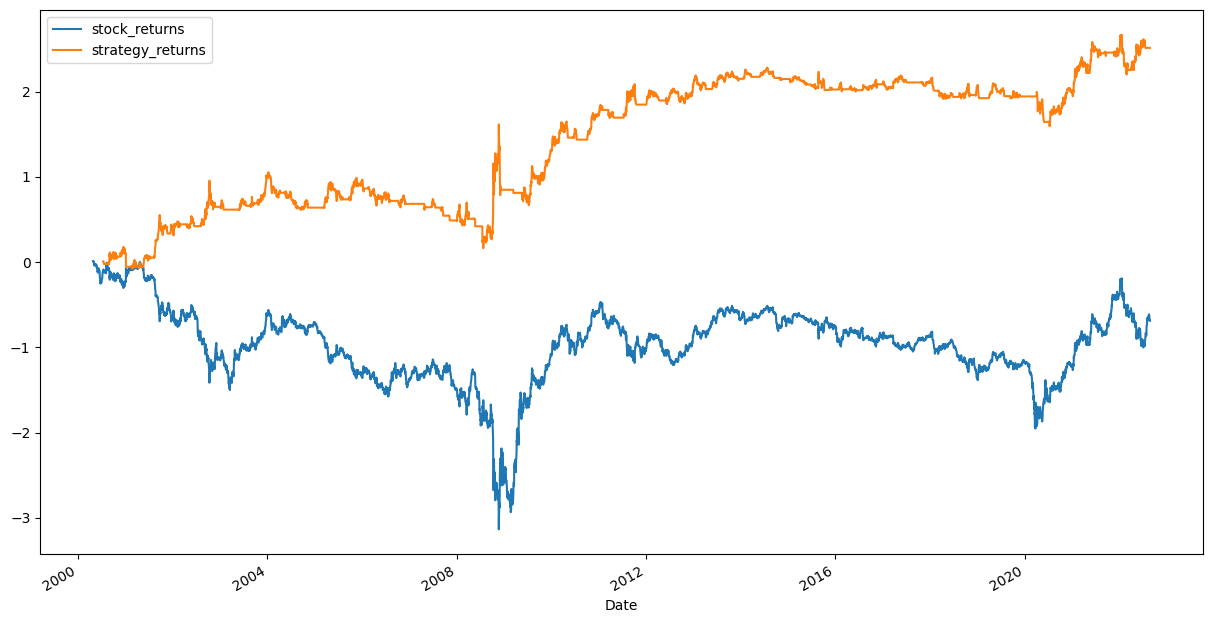

In [70]:
#below code checks the returns of stock itself and the strategy
df['stock_returns'] = np.log(df['Open']) - np.log(df['Open'].shift(1))
df['strategy_returns'] = df['stock_returns'] * df['position']
df[['stock_returns','strategy_returns']].cumsum().plot(figsize=(15,8))